# Machine Learning for SETI

## 1. Project Overview

Each night, using the Allen Telescope Array (ATA) in northern California, the SETI Institute scans the sky at various radio frequencies, observing star systems with known exoplanets, searching for faint but persistent signals. The current signal detection system is programmed to search only for particular kinds of signals: *narrow-band carrier waves*. However, the detection system sometimes triggers on *signals that are not narrow-band signals*  (with unknown efficiency) and are also not explicitly-known *radio frequency interference (RFI)*. There seems to be various categories of these kinds of events that have been observed in the past.

*Our goal is to classify these accurately in real-time*. This may allow the signal detection system to make better observational decisions, increase the efficiency of the nightly scans, and allow for explicit detection of these other signal types.

The standard approach to SETI signal detection and classification is to *transform the observed radio signals, which are time-series data, into a 2-dimensional representation called a spectrogram*. A spectrogram is a measure of the power of the signal across a range of frequencies, as a function of time. From this, the data acquisition software searches for narrowband signals. *By displaying the spectogram as a 2D image, this transform the  problem into a visual recognition problem.*

For example, here is a classic narrowband signal observered from the ISEE3 explorer. These are the kinds of signals the software is tuned to identify.

![](classic_narrowband_signal.jpg)

But things are usually never that pretty unless we're looking at a spacecraft. Here's another example: a mysterious squiggle observed in 2014 (the color scale is different because the power amplitude, coming out of the page is on a log-scale).

![](squiggle.jpg)

Similar to the signal above, *we often see various signal types that our software is not specifically designed to detect*. These have various names like "squiggles", "pulsed", and "bright pixels".

__*We want to build classification models that are designed to find these "other" types of signals*__. We hope to utilize the expertise from the data science community and simultaneously allow a way for citizen scientists to get involved in research that is normally out of their reach. We want to increase the number of large cups in the water, as Dr. Jill Tarter might describe it.

### 1.1 The Code Challenge

__*The challenge is to build a classification system based on a large body of simulated (and labeled) data that we have constructed*__. While our set of simulated data does not span the full range of types of signals observed at the ATA, or the complexity, it is a good starting point for building useful classification tools.

## 2. Data Preprocessing

The data consisted of total 7000 images of 2D spectogram with seven labels (brightpixel, narrowband, narrowbanddrd, noise, squarepulsednarrowband, squiggle, squigglessquarepulsednarrowband). The train data consisted of total 5600 images (800 images for each label). The validation and test data each have total of 700 images (100 images for each label).

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
# Define image height and width
img_height = 384
img_width  = 512

Using tf.keras.preprocessing.image_dataset_from_directory to generates a tf.data.Dataset from image files in a directory stored in local drive.

In [3]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    'exp_data', labels='inferred', label_mode="int",
    color_mode='rgb',batch_size=128, image_size=(img_height,img_width), shuffle=True,
    seed=123, validation_split=0.1, subset="training")

Found 5600 files belonging to 7 classes.
Using 5040 files for training.


In [4]:
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    'exp_data', labels='inferred', label_mode="int",
    color_mode='rgb', batch_size=128, image_size=(img_height,img_width), shuffle=True,
    seed=123, validation_split=0.1, subset="validation")

Found 5600 files belonging to 7 classes.
Using 560 files for validation.


At this point, we already have train dan validation data in the form (tf.data.Dataset) that can be used to train deep learning model developed using keras high-level API.

In [5]:
ds_train

<BatchDataset shapes: ((None, 384, 512, 3), (None,)), types: (tf.float32, tf.int32)>

In [6]:
class_names = ds_train.class_names
print(class_names)

['brightpixel', 'narrowband', 'narrowbanddrd', 'noise', 'squarepulsednarrowband', 'squiggle', 'squigglesquarepulsednarrowband']


In [7]:
len(class_names)

7

In [8]:
class_names[0]

'brightpixel'

In [9]:
class_names[len(class_names)-1]

'squigglesquarepulsednarrowband'

### 2.1 Visualize the Data

Let's take a look of some of the train data.

In [ ]:
# Take the first batch of training data.
train_batch = ds_train.take(1)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Plot 9 images from the 1st batch.
plt.figure(figsize=(15, 15))

for images,labels in train_batch:
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
images.shape

In [ ]:
labels.shape

The images (from batch 1) is a tensor of the shape (32, 384, 512, 3). This is a batch of 32 images of shape 384x512x3 (the last dimension referes to color channels RGB). The label (from batch 1) is a tensor of the shape (32,), these are corresponding labels to the 32 images.

### 2.2 Data Rescaling

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

In [ ]:
#Plot figure of an image.
plt.figure()
plt.imshow(images[i].numpy().astype("uint8"))

plt.colorbar()  #Show color bar
plt.grid(False) #No grid

plt.show()      #Show image

In [ ]:
print("Min and max pixel values:", images[i].numpy().min(), images[i].numpy().max())

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer. The rescaling layer can be added later when building CNN model

### 2.3 Resize Images

The original image size will yield too many parameters that cause the optimization process took longer time. Thus we will resize the images size.

In [10]:
from tensorflow.keras import layers

In [11]:
# Resize to 32x32.
# Define a function to resize and rescaling.
IMG_SIZE = 32

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

Lets test above function to an image:

In [ ]:
result = resize_and_rescale(images[i])
_ = plt.imshow(result)

In [ ]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Now we resize and rescale all of images in training and evaluation data using lambda function.

In [12]:
aug_train_ds = ds_train.map(lambda x, y: (resize_and_rescale(x), y))
aug_val_ds = ds_validation.map(lambda x, y: (resize_and_rescale(x), y))

Check both training and validation data:

In [13]:
aug_train_ds

<MapDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int32)>

In [14]:
aug_val_ds

<MapDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int32)>

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

aug_train_ds = aug_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
aug_val_ds = aug_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Plot images after resize and rescaling:

In [ ]:
# Take the first batch of data.
train_batch = aug_train_ds.take(1)

In [ ]:
plt.figure(figsize=(15,15))

for images,labels in train_batch:
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
#         plt.imshow(images[i].numpy().astype("uint8"))
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 2B. SETI Simulated Signals - Data Exploration

This kernel takes a look at the SETI data, focussing on the raw data stored in the primary_small_v3/ folder. Note that the primary_small/ folder contains the data converted into PNG files and broken down into training, validation and testing folders.

First, let's import the customer ibmseti module,

In [1]:
import ibmseti

Now, set the path to the raw data,

In [2]:
path = 'primary_small_v3/primary_small_v3/'

Let's take a look at one of the files, using the ibmseti package,

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [4]:
primarymediumlist = os.listdir(path)
firstfile = primarymediumlist[0]
print(path + firstfile)

primary_small_v3/primary_small_v3/0011232d-2713-4919-8d4a-fc782da42865.dat


In [5]:
data_1 = ibmseti.compamp.SimCompamp(open(path + firstfile,'rb').read())
data_1.header().get("signal_classification")

'squiggle'

Let's get the spectrogram from the data and plot it,

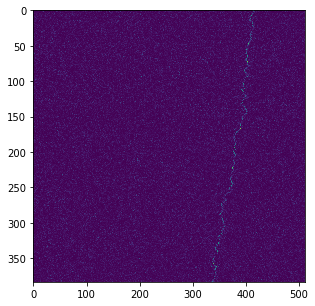

In [6]:
spectrogram = data_1.get_spectrogram()

fig, ax = plt.subplots(figsize=(10,5))
ax.imshow(spectrogram, aspect = spectrogram.shape[1] / spectrogram.shape[0])

There are in total 7 different classes of signals simulated by SETI. The link above gives an introduction to the different types, and there is also an open-access paper with more details here. The classes have the following names,

- noise
- squiggle
- narrowband
- narrowbanddrd
- squarepulsednarrowband
- squigglesquarepulsednarrowband
- brightpixel

Let's take a look at examples of each,

In [7]:
def plot_spectrogram(index_num):
    file = primarymediumlist[index_num]
    data = ibmseti.compamp.SimCompamp(open(path + file,'rb').read())
    spectrogram = data.get_spectrogram()
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title(data.header().get("signal_classification"))
    ax.imshow(spectrogram,  aspect = spectrogram.shape[1] / spectrogram.shape[0])

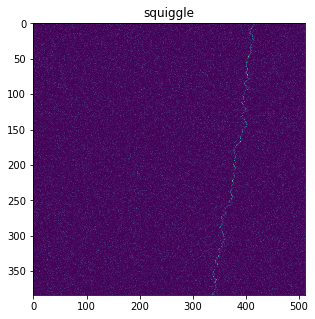

In [8]:
plot_spectrogram(0) #squiggle

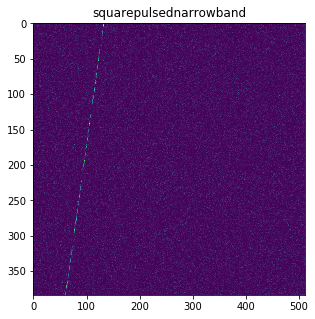

In [9]:
plot_spectrogram(2) #squarepulsednarrowband

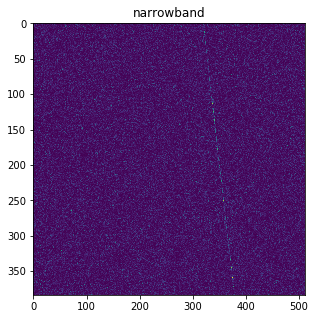

In [10]:
plot_spectrogram(5) #narrowband

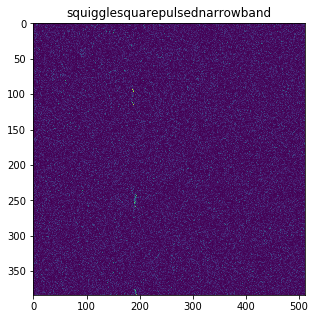

In [11]:
plot_spectrogram(11) #squigglesquarepulsednarrowband

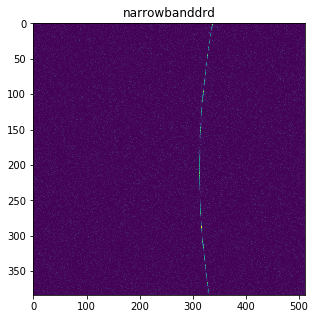

In [12]:
plot_spectrogram(14) #narrowbanddrd

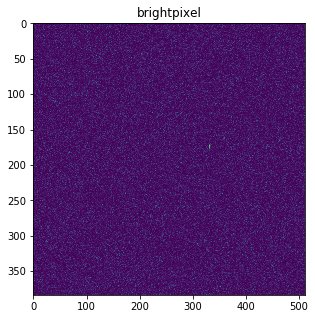

In [13]:
plot_spectrogram(15) #brightpixel

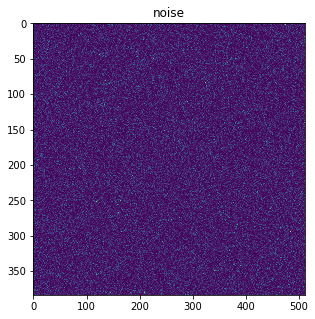

In [14]:
plot_spectrogram(17) #noise

Below is a histogram of the first example (the squiggle),

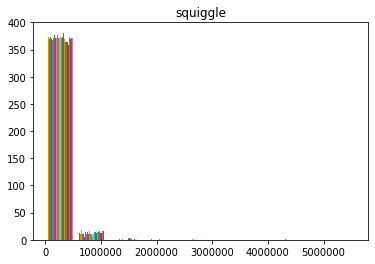

In [15]:
plt.hist(spectrogram)
plt.title(data_1.header().get("signal_classification"))
plt.show()

The SETI folk over on the GitHub pages take the log of the spectrogram, which gives a better spread,

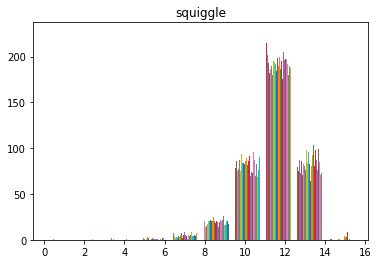

In [16]:
plt.hist(np.log(spectrogram))
plt.title(data_1.header().get("signal_classification"))
plt.show()

## 3. Build CNN Model

Let's build a simple CNN model to classify the histogram images.

In [16]:
from tensorflow.keras import layers, models

In [ ]:
num_classes = 7

model = models.Sequential()

# Rescaling pixel values to [0,1].
# model.add(layers.experimental.preprocessing.Rescaling(1./255))

# First convolutional layer.
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(layers.MaxPooling2D(2,2))

# Second convolutional layer.
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# Third convolutional layer.
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# Fully connected classifier.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes))

In [ ]:
model.summary()

Choose optimizer, loss function and metric:

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Next, fit the model to training data:

In [ ]:
# Try batch size = 128
# model.fit(aug_train_ds, batch_size=128, epochs=30)
# model.fit(aug_train_ds, epochs=30)
# model.fit(aug_train_ds, batch_size=128, epochs=150)
model.fit(aug_train_ds, batch_size=128, epochs=150, verbose=2)

In [ ]:
model.evaluate(aug_val_ds, verbose=2)

Our model is obviously overfit. Its to equip our model with regularization.

### 3.1 CNN Model with Regularization

In [17]:
from tensorflow.keras import regularizers

Combined L2 and dropout:

In [25]:
num_classes = 7

model = models.Sequential()

# Rescaling pixel values to [0,1].
# model.add(layers.experimental.preprocessing.Rescaling(1./255))

# First convolutional layer.
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(layers.MaxPooling2D(2,2))
# model.add(layers.Dropout(0.5))

# Second convolutional layer.
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Dropout(0.5))

# Third convolutional layer.
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Dropout(0.5))

# Forth convolutional layer.
# model.add(layers.Conv2D(256, (3,3), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))

# Flattening layer.
model.add(layers.Flatten())

# First fully-connected layer.
model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
# model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

# Second fully-connected layer.
model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model.add(layers.Dropout(0.5))

# Third fully-connected layer.
# model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
# model.add(layers.Dropout(0.5))

# Output layer.
model.add(layers.Dense(num_classes))

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)              

In [31]:
initial_learning_rate = 0.1
decay_steps = 1.0
decay_rate = 0.01

learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate, 
                                                               decay_steps, decay_rate)

In [38]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate_fn),
#                                       loss='sparse_categorical_crossentropy', 
#                                       metrics=['accuracy'])

In [39]:
model.fit(aug_train_ds, batch_size=128, epochs=150, verbose=2)

Epoch 1/150
40/40 - 5s - loss: 3.2833 - accuracy: 0.1331
Epoch 2/150
40/40 - 4s - loss: 2.0175 - accuracy: 0.1421
Epoch 3/150
40/40 - 4s - loss: 2.0090 - accuracy: 0.1450
Epoch 4/150
40/40 - 4s - loss: 2.0036 - accuracy: 0.1462
Epoch 5/150
40/40 - 4s - loss: 1.9995 - accuracy: 0.1468
Epoch 6/150
40/40 - 4s - loss: 1.9961 - accuracy: 0.1474
Epoch 7/150
40/40 - 4s - loss: 1.9933 - accuracy: 0.1474
Epoch 8/150
40/40 - 4s - loss: 1.9908 - accuracy: 0.1490
Epoch 9/150
40/40 - 4s - loss: 1.9886 - accuracy: 0.1490
Epoch 10/150
40/40 - 4s - loss: 1.9867 - accuracy: 0.1472
Epoch 11/150
40/40 - 4s - loss: 1.9848 - accuracy: 0.1472
Epoch 12/150
40/40 - 4s - loss: 1.9831 - accuracy: 0.1472
Epoch 13/150
40/40 - 4s - loss: 1.9815 - accuracy: 0.1472
Epoch 14/150
40/40 - 4s - loss: 1.9801 - accuracy: 0.1472
Epoch 15/150
40/40 - 4s - loss: 1.9789 - accuracy: 0.1472
Epoch 16/150
40/40 - 4s - loss: 1.9775 - accuracy: 0.1472
Epoch 17/150
40/40 - 4s - loss: 1.9764 - accuracy: 0.1472
Epoch 18/150
40/40 - 4s

Epoch 142/150
40/40 - 3s - loss: 1.9494 - accuracy: 0.1470
Epoch 143/150
40/40 - 3s - loss: 1.9494 - accuracy: 0.1470
Epoch 144/150
40/40 - 3s - loss: 1.9494 - accuracy: 0.1470
Epoch 145/150
40/40 - 3s - loss: 1.9494 - accuracy: 0.1470
Epoch 146/150
40/40 - 3s - loss: 1.9494 - accuracy: 0.1470
Epoch 147/150
40/40 - 3s - loss: 1.9494 - accuracy: 0.1470
Epoch 148/150
40/40 - 3s - loss: 1.9494 - accuracy: 0.1470
Epoch 149/150
40/40 - 3s - loss: 1.9494 - accuracy: 0.1470
Epoch 150/150
40/40 - 3s - loss: 1.9494 - accuracy: 0.1470


In [30]:
model.evaluate(aug_val_ds, verbose=2)

5/5 - 1s - loss: 1.9783 - accuracy: 0.1554


[1.9783178567886353, 0.15535713732242584]

## 3B. SETI Simulated Signals - InceptionResNetV2

SETI have been getting serious about AI recently. After all, what better solution to the problem of too much data?

This kernel takes a Keras pre-trained model (InceptionResNetV2) and trains it on the PNGs produced from the SETI simulated 'primary small' dataset.

Let's start by loading the required modules,

In [34]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [17]:
import os

# import tensorflow as tf
# from tensorflow import keras

from tensorflow.keras import applications
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing import image

import numpy as np
import math
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings

warnings.filterwarnings('ignore')

Create a few constants,

In [18]:
train_dir = 'primary_small/train/'
validation_dir = 'primary_small/valid/'
test_dir = 'primary_small/test/'

img_dim  = 197

Now, let's use Keras to train the model. The first step is to create some data generators to flow the data into the training process. I'm going to use some data augmentation to expand the dataset. Note ... some of the signal types look very similar to each other. For example, 'narrowbanddrd' is basically just a slightly curved version of 'narrowband'. I suspect that some augmentation transformations such as skewing could make one type look like another, so beware!

In [19]:
#Generators
train_datagen = ImageDataGenerator(
  rotation_range = 180,
  horizontal_flip = True,
  vertical_flip = True,
  fill_mode = "reflect")

# Note that the validation data shouldn't be augmented!
validation_datagen = ImageDataGenerator()  
test_datagen = ImageDataGenerator()  

In [20]:
training_batch_size = 64
validation_batch_size = 64

train_generator = train_datagen.flow_from_directory(
  train_dir,                                                  
  classes = ('noise', 'squiggle', 'narrowband', 'narrowbanddrd', 'squarepulsednarrowband', 
            'squigglesquarepulsednarrowband', 'brightpixel'),
  target_size = (img_dim, img_dim),            
  batch_size = training_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 5600 images belonging to 7 classes.


In [21]:
validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  classes = ('noise', 'squiggle', 'narrowband', 'narrowbanddrd', 'squarepulsednarrowband', 
            'squigglesquarepulsednarrowband', 'brightpixel'),
  target_size = (img_dim, img_dim),
  batch_size = validation_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 700 images belonging to 7 classes.


In [22]:
test_size = 700
test_batch_size = 1

test_generator = test_datagen.flow_from_directory(
  test_dir,
  classes = ('noise', 'squiggle', 'narrowband', 'narrowbanddrd', 'squarepulsednarrowband', 
            'squigglesquarepulsednarrowband', 'brightpixel'),
  target_size = (img_dim, img_dim),
  batch_size = test_batch_size,
  class_mode = "categorical",
  shuffle = False)

Found 700 images belonging to 7 classes.


Next, load the InceptionResNetV2 model from keras. Note that you have to import the weights as as separate 'dataset' in Kaggle,

In [23]:
base = InceptionResNetV2(
  weights = 'imagenet',
  include_top = False,
  input_shape = (img_dim, img_dim, 3)
)

I need to tweak this model to make predictions for the 7 signal categories. Notice that I didn't include the 'top' in the above step, the 'top' being the output layers in the original model. Below adds a bespoke top. Notice the 7-output softmax layer,

In [24]:
x = base.output
x = Flatten(input_shape=base.output_shape[1:])(x)
x = Dense(img_dim, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(7, activation="softmax")(x)

Now, let's merge the 'base' with the custom 'top',

In [25]:
model = Model(inputs=base.input, outputs=x)

I've played around with transfer learning using ImageNet weights from various depths of the model, but performance wasn't great. Let's just allow the whole thing to be trained,

In [26]:
for layer in model.layers:
    layer.trainable = True

Let's compile the model. I've not played around a great deal with the optimiser choice or hyperparameters, but this seems to work reasonable well,

In [27]:
model.compile(loss = "binary_crossentropy", optimizer = optimizers.RMSprop(lr=1e-4), 
              metrics=["accuracy"])

We can now train the model,

In [45]:
#Train

training_step_size = 64
validation_step_size = 32

history = model.fit_generator(
  train_generator,
  steps_per_epoch = training_step_size,
  epochs = 50,
  validation_data = validation_generator,
  validation_steps = validation_step_size,
  verbose = 0,
)

KeyboardInterrupt: 